# Volatility modeling with GARCH

We will use stock return data to illustrate volatility modeling in the GARCH framework, with an application to calculating Value at Risk (VaR).

In [1]:
import arch
from arch.__future__ import reindexing

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import math

import scipy.stats
from scipy.optimize import minimize

import wrds

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os
from dotenv import load_dotenv
load_dotenv();

In [2]:
conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])
data_daily = conn.raw_sql("select caldt, vwretd, spindx from crsp_a_indexes.dsp500")
conn.close()
data_daily['date'] = pd.to_datetime(data_daily['caldt'])
data_daily = data_daily.drop(columns=['caldt']).set_index('date')
data_daily = data_daily['1980-01':'2020-03']
data_daily = data_daily.dropna()
returns = np.log(1+data_daily['vwretd']).astype("float64")
spindx = data_daily['spindx'].astype("float64")

Loading library list...
Done


# Visualize time-varying volatility

Volatility in stock returns seems to be highly persistent, meaning that once high it tends to stay high for a while:

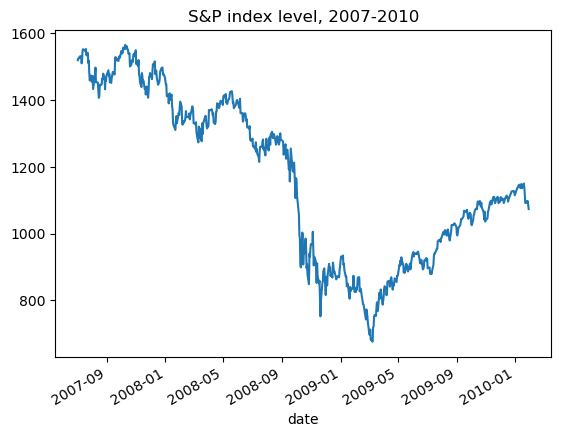

In [3]:
spindx['2007-07':'2010-01'].plot(title="S&P index level, 2007-2010");

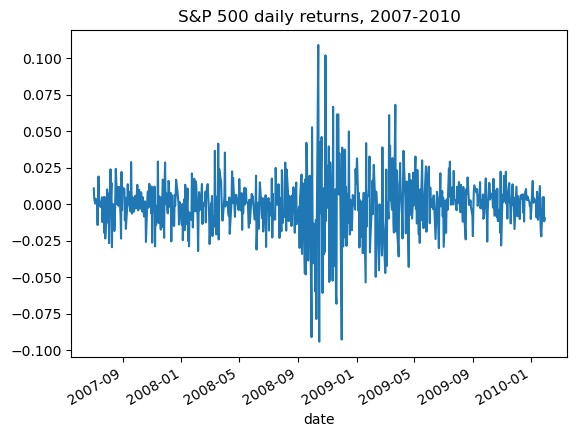

In [4]:
returns['2007-07':'2010-01'].plot(title="S&P 500 daily returns, 2007-2010");

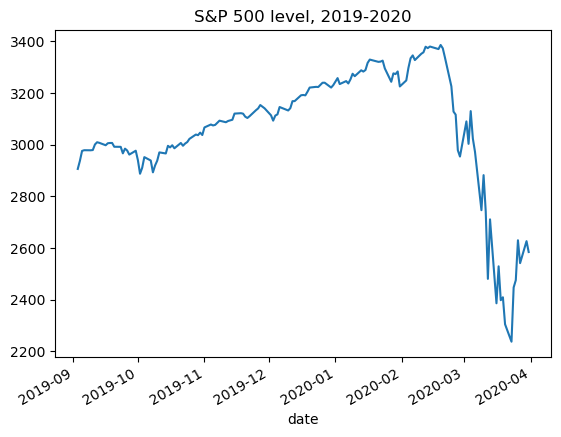

In [5]:
spindx['2019-09':'2020-03'].plot(title="S&P 500 level, 2019-2020");

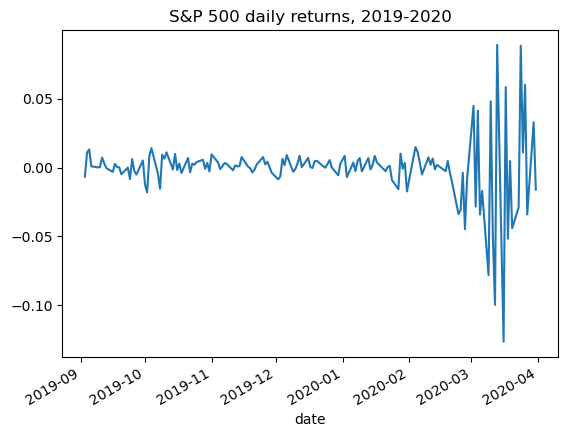

In [6]:
returns['2019-09':'2020-03'].plot(title="S&P 500 daily returns, 2019-2020");

More formally, the *squared* return on any date is an estimate of the volatility at that date, so we can get a sense of what volatility is doing by calculating squared returns and examining their behavior.

In [7]:
returns_squared = returns**2

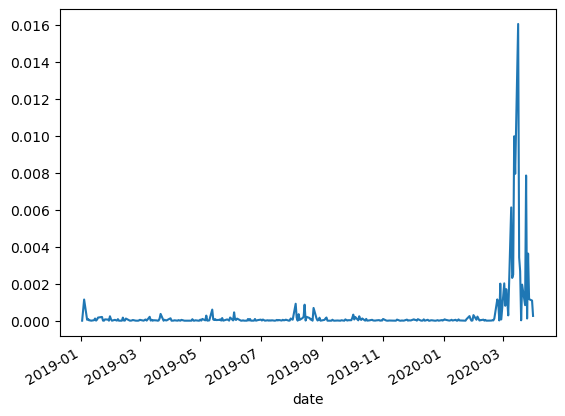

In [8]:
returns_squared['2019':].plot();

First let's look at the ACF and PACF of the squared return. It clearly looks like there is some predictability in this process, that is, some persistence in volatility.

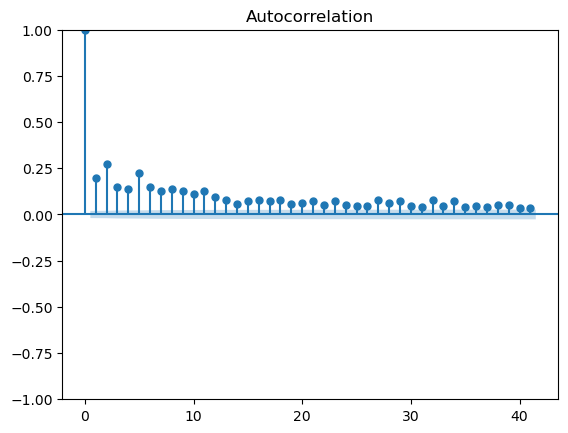

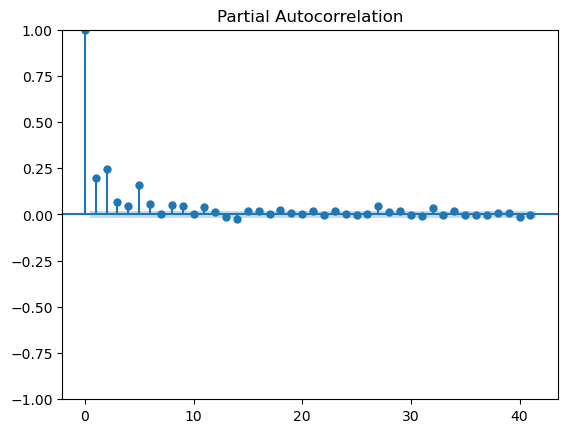

In [9]:
plot_acf( returns_squared );
plot_pacf( returns_squared );

# Test for predictability in volatility

The most formal way to check for predictability is with Engle's ARCH-LM test. This is implemented by the command het_arch in statsmodels. As usual, the second number is the p-value (under the null of no predictability of volatility).

Force the test to use one lag:

In [10]:
het_arch(returns,nlags=1)

(np.float64(386.57945351197554),
 np.float64(4.597721746132495e-86),
 401.8098714888017,
 1.0934064901533917e-87)

Allow the test to use its default of $\sqrt{T}$ lags (rounding down):

In [11]:
het_arch(returns)

(np.float64(1355.627838883554),
 np.float64(3.766625223168444e-285),
 156.31580331975195,
 1.9358416406330298e-306)

The tiny p-values in both tests tell us to reject the null hypothesis that there is no predictability in volatility.

**Technical point that will be important below:** Strictly speaking, Engle's ARCH-LM test should be applied to *standardized* values (where "standardize" means "divide by standard deviation"). Here, the test wants us to divide the returns by volatility $r/\sigma$. 

For the current analysis this is just a cosmetic issue: Before we do any volatility modeling, our "forecast" of volatility at each date is just the sample standard deviation of returns $\hat{\sigma}$, so "standardized" returns would just be $r_t / \hat{\sigma}$. Since the ARCH-LM test is based on a regression $R^2$, it does not change when we rescale all the data by a constant in this manner. 

To illustrate, the next command calculates "standardized" returns based on sample standard deviation, and repeats the ARCH-LM test. This is theoretically the correct thing to do, but the output is exactly the same as before:

In [12]:
standardized_returns = returns / returns.std()
het_arch(standardized_returns,nlags=1)

(np.float64(386.57945351198117),
 np.float64(4.597721746119492e-86),
 401.8098714888074,
 1.0934064901501906e-87)

In [13]:
het_arch(standardized_returns)

(np.float64(1355.6278388835583),
 np.float64(3.7666252231607215e-285),
 156.31580331975255,
 1.935841640627968e-306)

But this issue will become more important after we estimate the GARCH model. In order to check that we have successfully accounted for the time-varying patterns of volatility, we will apply the ARCH-LM test to the residuals from the estimation. At that point, it <b>will</b> be very important that we test *standardized* residuals $\hat{u}_t / \hat{\sigma}_t$ because there really will be different values of $\sigma_t$ at different points in time. See below.

Finally, it may be helpful for understanding to show how to match the first test statistic above by hand: Estimate an $AR(q)$ model of the squared daily returns, where $q$ is the number of lags (1 in this case). Multiply the $R^2$ from this regression by the number of observations. Under the null hypothesis of no predictability in volatility, this product is distributed as $\chi_q^2$.

In [14]:
ols_results = ols("returns_squared ~ returns_squared.shift()",data=returns_squared).fit()
print( ols_results.rsquared*ols_results.nobs )

386.57945351197554


# Smoothing-based descriptions of persistent volatility

Squared returns as a simple estimate of volatility:

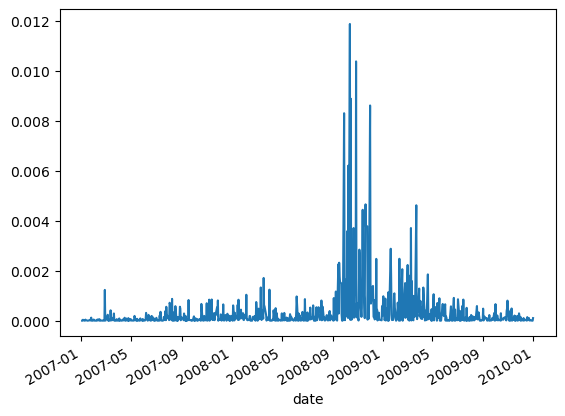

In [15]:
returns_squared['2007':'2009'].plot();

Centered moving average to smooth out fluctuations. Let's try a 12-day centered average:

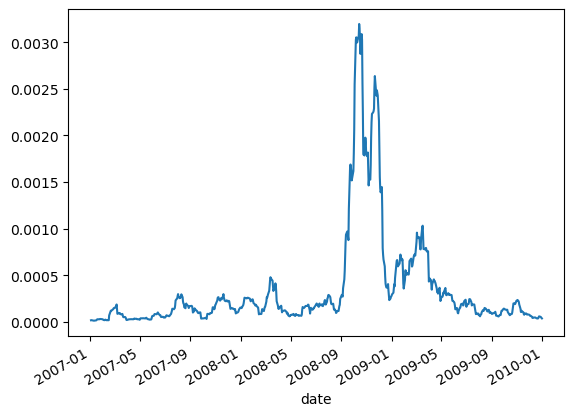

In [16]:
vol_CMA = (1/12)*( 0.5*returns_squared.shift(6) + returns_squared.shift(5) + returns_squared.shift(4)
                     + returns_squared.shift(3) + returns_squared.shift(2) + returns_squared.shift(1)
                     + returns_squared.shift(0)
                     + returns_squared.shift(-1) + returns_squared.shift(-2) + returns_squared.shift(-3)
                     + returns_squared.shift(-4) + returns_squared.shift(-5) + 0.5*returns_squared.shift(-6) )
vol_CMA['2007':'2009'].plot();

We can also follow an exponential smoothing approach. Exponential smoothing of volatility is usually labeled EWMA (exponential weighted moving average), but it's the same idea as exponential smoothing that we covered weeks ago, just applied to squared returns. 

Here's a function that takes a value of $\alpha$ as input and returns a smoothed volatility series:

In [17]:
def get_var_EWMA(alpha):
    EWMA = pd.concat([returns_squared])
    var_EWMA = pd.Series(index=returns_squared.index,dtype='float64')
    var_EWMA = var_EWMA[var_EWMA.index.year > 1980]
    var_EWMA.iloc[0] = returns_squared['1980'].mean()
    for i in range(1,len(var_EWMA)):
        var_EWMA.iloc[i] = alpha*returns_squared.loc[var_EWMA.index[i-1]] + (1-alpha)*var_EWMA.iloc[i-1]
    return var_EWMA

Exponential smoothing with $\alpha = 0.1$ generates a similar-looking figure to our centered moving average:

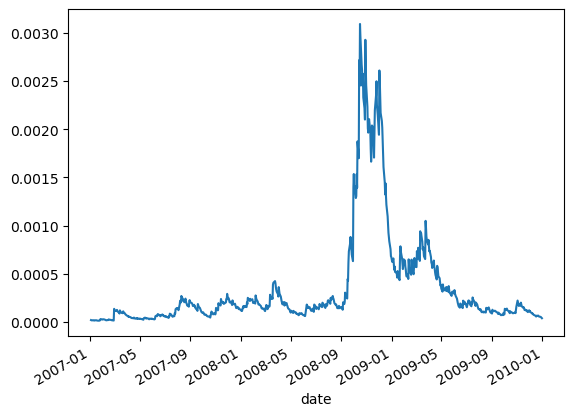

In [18]:
var_EWMA = get_var_EWMA(0.1)
var_EWMA['2007':'2009'].plot();

However, EWMA models are typically estimated with much higher values of $\alpha$. This effectively moves *away* from doing much smoothing and instead focuses heavily on the most recent squared returns. A common value recommended by RiskMetrics is 0.94. You can see that the resulting figure is much more jagged and very similar to the simple data figure that we started with.

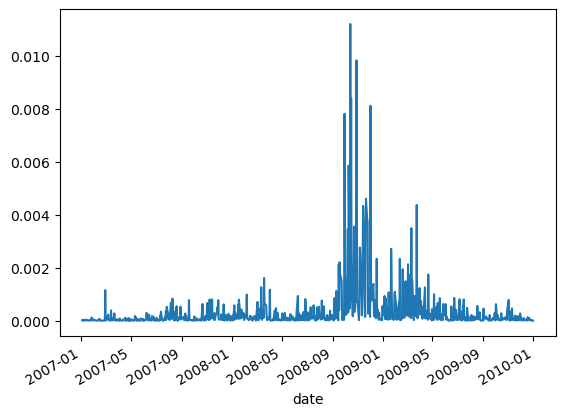

In [19]:
var_EWMA = get_var_EWMA(0.94)
var_EWMA['2007':'2009'].plot();

Like the smoothing-based approaches we saw at the beginning of the course, smoothing-based volatility models are a simple and effective way to summarize changes in volatility over time. 

Our main focus will be on GARCH models, which are much like the ARMA framework: They are grounded in a much more formal school of thought that tries to estimate the underlying process that generates the data. This approach takes a bit more work but is important if you pursue tasks beyond forecasting.

# Estimate models of persistent volatility

## ARCH(1) model

The most basic model of time-varying volatility is called ARCH ("autoregressive conditional heteroskedasticity"), which specifies 
$$ y_t = \mu + u_t \, , \quad u_t \sim \mathscr{N}(0,\sigma_t^2) $$
and 
$$ \sigma_t^2 = \omega + \alpha \, u_{t-1}^2 $$

We can estimate this model with the arch_model command from the arch package in Python, and specifying the option vol='arch'. This command will estimate the model by MLE.

In [20]:
ARCH1_results = arch.arch_model(100*returns,vol='arch').fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18310523.244649798
Iteration:      2,   Func. Count:     13,   Neg. LLF: 22796.65925294452
Iteration:      3,   Func. Count:     20,   Neg. LLF: 15832.889740166403
Iteration:      4,   Func. Count:     25,   Neg. LLF: 14796.041346555963
Iteration:      5,   Func. Count:     29,   Neg. LLF: 14796.024026033947
Iteration:      6,   Func. Count:     33,   Neg. LLF: 14796.023347397593
Iteration:      7,   Func. Count:     37,   Neg. LLF: 14796.023327481838
Iteration:      8,   Func. Count:     40,   Neg. LLF: 14796.023327481904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14796.023327481838
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8


In [21]:
print( ARCH1_results.summary() )

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                 vwretd   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -14796.0
Distribution:                  Normal   AIC:                           29598.0
Method:            Maximum Likelihood   BIC:                           29619.7
                                        No. Observations:                10149
Date:                Thu, Jan 15 2026   Df Residuals:                    10148
Time:                        10:25:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0612  1.130e-02      5.420  5.952e-08 [3.

To check our understanding, we can (almost) match the MLE estimation of the ARCH model by coding up a minimization routine.

In [22]:
# This returns the negative of the (log) likelihood function for any given set of parameters. See Wooldridge p.660
def negative_ll(params):
    omega,alpha,mu = params
    N = len(returns)
    eps = 100*returns - mu
    sigma2 = np.zeros(N)
    sigma2[0] = max( 0.000001, omega/(1.000 - alpha) )
    for i in range(1,N):
        sigma2[i] = omega + alpha*(eps[i-1]**2)
    return( (np.log(sigma2) + eps**2/sigma2)[1:].sum() )

# This searches out the parameters that maximize the likelihood (i.e. minimize the negative of the likelihood)
ARCH_params_manual = minimize( \
                negative_ll , \
                [ returns.std() , 0, 0 ] , \
                bounds=((0,None),(0,None),(None,None)) \
               ).x

print("mu: " + '%5.4f' % ARCH_params_manual[2])
print("omega: " + '%5.4f' % ARCH_params_manual[0])
print("alpha: " + '%5.4f' % ARCH_params_manual[1])

mu: 0.0614
omega: 0.8415
alpha: 0.3201


Visualize the fitted values of volatility over time.

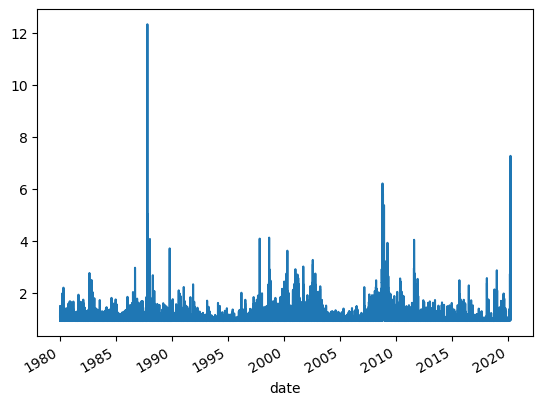

In [23]:
ARCH1_results.conditional_volatility.plot();

Plot the ACF and PACF of squared *standardized* residuals ($\hat{u}_t/\hat{\sigma}_t$) to see if there are any important remaining time-series patterns in volatility.

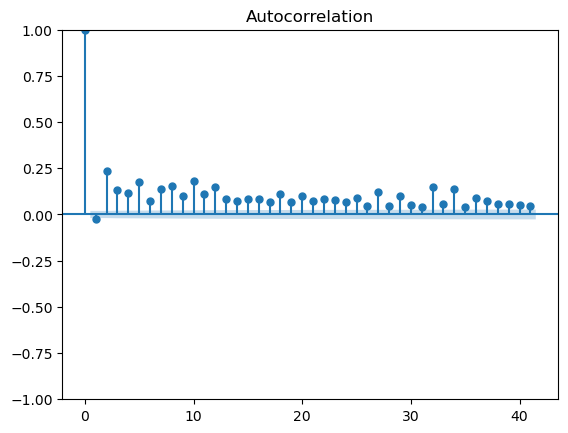

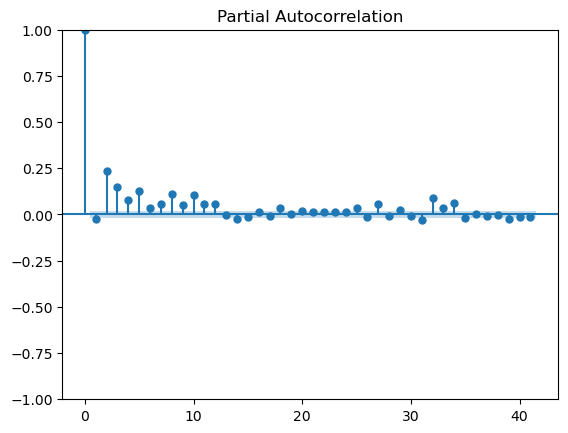

In [24]:
ARCH1_resid_standardized = ARCH1_results.resid / ARCH1_results.conditional_volatility
plot_acf(  ARCH1_resid_standardized**2 );
plot_pacf( ARCH1_resid_standardized**2 );

We still see some large patterns in these plots.

Consistent with this, we also see that the ARCH-LM test continues to reject the null hypothesis that we have captured everything:

In [25]:
het_arch( ARCH1_resid_standardized, nlags=1 )

(np.float64(5.027551515792138),
 np.float64(0.024947142942609316),
 5.029052177584612,
 0.02494704288912948)

In [26]:
het_arch( ARCH1_resid_standardized )

(np.float64(1267.7625282371882),
 np.float64(3.4628213897512735e-266),
 144.73627751320717,
 1.1532033557330174e-284)

So far, it seems like we don't yet have an adequate model for volatility in this data.

Intuitively, when we look at the ACF and PACF of squared returns (which are a proxy for volatility), we see a gentle declining pattern that reminds us of an AR process. But the ARCH volatility model looks more like an MA(1) process. It only picks up on persistence through one "shock" that immediately stops mattering afterwards. When we look at the ACF and PACF of the residuals from the ARCH model, we can see that the computer is able to then pick up on the connections at a distance of 1 date, but not at any higher dates, leaving a lot on the table.

What to do about this? Within the ARCH framework, the only thing we could do is to start adding more lags into the model. This would lead us to what is called an ARCH(p) model, where the volatility equation includes $p$ lages of $u^2$:
$$
\sigma_t^2 = \omega + \alpha_1 u_{t-1}^2 + \alpha_2 u_{t-2}^2 + ... + \alpha_p u_{t-p}^2
$$
Models like this are sometimes estimated in practice, but in our situation this is not a very attractive way to solve the problem we're seeing. We would end up asking the computer to estimate many different values of $\alpha$, when it seems like there is likely a simpler relationship that does not require so many parameters to estimate. 

The better approach is to revise our model to allow for true "long-memory" AR-style behavior in volatility. This is exactly what is accomplished by GARCH models, which have essentially replaced ARCH for most financial modeling. This is our next topic.

## GARCH(1,1) model

The GARCH(1,1) mode generalizes things slightly by specifying
$$ y_t = \mu + u_t \, , \quad u_t \sim \mathscr{N}(0,\sigma_t^2) $$
and
$$ \sigma_t^2 = \omega + \alpha \, u_{t-1}^2 + \beta \, \sigma_{t-1}^2 $$
By adding in the last term in the last equation above, we have a way of flexibly capturing "long-memory" or slow-decaying patterns in volatility, much like an AR term in the ARMA framework. We can continue to estimate this model by MLE.

In [27]:
GARCH11_results = arch.arch_model(100*returns,vol='garch',p=1,q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 89851779210.38498
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5786636830.544849
Iteration:      3,   Func. Count:     24,   Neg. LLF: 18603.782207674314
Iteration:      4,   Func. Count:     32,   Neg. LLF: 13626.014762993083
Iteration:      5,   Func. Count:     38,   Neg. LLF: 13480.78869531402
Iteration:      6,   Func. Count:     44,   Neg. LLF: 13644.956641601222
Iteration:      7,   Func. Count:     50,   Neg. LLF: 13457.544505436785
Iteration:      8,   Func. Count:     55,   Neg. LLF: 13457.546444243239
Iteration:      9,   Func. Count:     61,   Neg. LLF: 13457.534873670795
Iteration:     10,   Func. Count:     66,   Neg. LLF: 13457.534865845295
Iteration:     11,   Func. Count:     70,   Neg. LLF: 13457.534865844194
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13457.534865845295
            Iterations: 11
            Function evaluations: 70
            Gradient evalua

In [28]:
GARCH11_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 vwretd   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13457.5
Distribution:                  Normal   AIC:                           26923.1
Method:            Maximum Likelihood   BIC:                           26952.0
                                        No. Observations:                10149
Date:                Thu, Jan 15 2026   Df Residuals:                    10148
Time:                        10:25:53   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0701  8.271e-03      8.479  2.270e-17 [5.392e-02,8.634e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0186  4.514e-03      4.125  3.702e-05 [9.775e-03,2.747e-02]
alpha[1]       0.0980  1.589e-02      6.167  6.971e-10   [6.683e-02,  0.129]
beta[1]        0.8875  1.651e-02     53.768      0.000     [  0.855,  0.920]
============================================================================

Covariance estimator: robust
"""

Plot the ACF and PACF of squared standardized residuals ($\hat{u}_t/\hat{\sigma}_t$) to see if there are any important remaining time-series patterns in volatility.

In [29]:
GARCH11_resid_standardized = GARCH11_results.resid / GARCH11_results.conditional_volatility

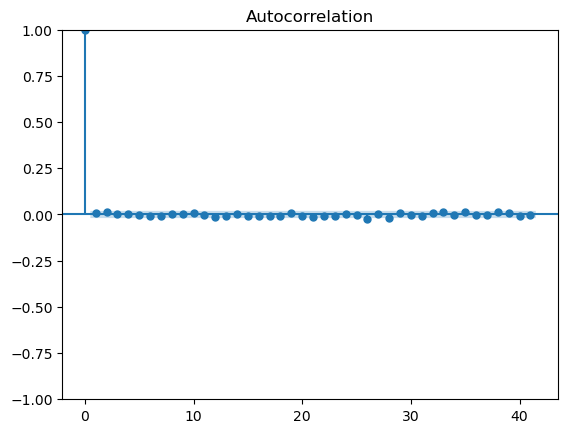

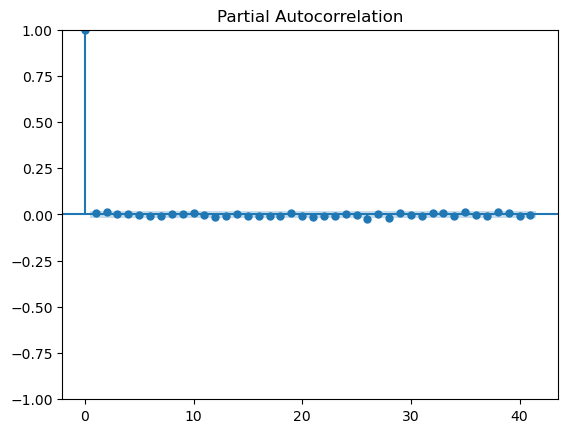

In [30]:
plot_acf( GARCH11_resid_standardized**2);
plot_pacf(GARCH11_resid_standardized**2);

Check that the ARCH-LM test now fails to reject the null of no predictability in volatility.

In [31]:
het_arch( GARCH11_resid_standardized , nlags=1 )

(np.float64(0.7015515097717642),
 np.float64(0.4022628550815922),
 0.7014617392279526,
 0.40231269203540576)

In [32]:
het_arch( GARCH11_resid_standardized )

(np.float64(4.780630708391442),
 np.float64(0.9053420210443683),
 0.47776968358615096,
 0.905477420768363)

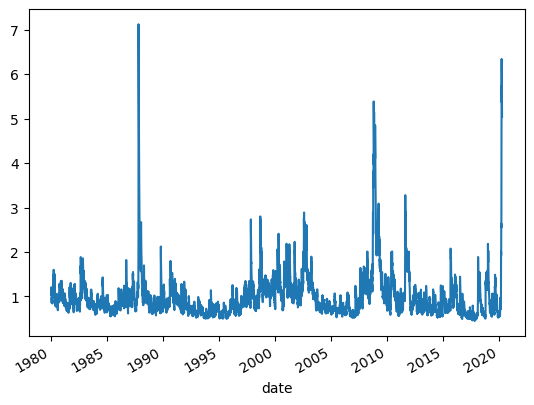

In [33]:
GARCH11_results.conditional_volatility.plot();

Conclusion: The GARCH model is far superior to ARCH for this series. Volatility is very persistent and slow-decaying, so performance is much better when we make that behavior part of the model. Again, this is a typical finding in financial markets, and for this reason GARCH is the standard choice for volatility modeling.

One small technical note. I have drawn the analogy that the $\alpha \, u_{t-1}^2$ part of our volatility model is like an MA term, and the $\beta \, \sigma_{t-1}^2$ is like an AR term. In that sense the ARCH model feels like an MA(1) model for volatility, and the GARCH(1,1) model feels like an ARMA(1,1) for volatility. You might wonder, what type of volatility model would feel like an AR(1)? This would be something like $\sigma_t^2 \, = \, \omega \, + \, \beta \, \sigma_{t-1}^2$. But we cannot actually implement such a model. (Or more precisely, it would be a "degenerate" model that does nothing useful for us.) This is because there is now no direct connection between that volatility model and the mean model $y_t = \mu + u_t$. To be useful, the volatility model always has to have some dependence on the data $y_t$ that we can directly observe, or else on the shocks $u_t$ that we can infer from the model for $y_t$. Otherwise it becomes a pure abstraction with no implication for the data.

# Application: Value at risk calculations

Let's imagine calculating the "value at risk" of an S&P 500 index portfolio at any point in time. First we will do this ignoring persistence in volatility. Then we will repeat the calculation taking into account the effects that were captured by our GARCH model.

### Overview of value at risk (VAR)

Value at risk (VAR) is just a percentile of returns over some future horizon. 

For example, the 7-day, 5% VAR is the 5th percentile of the distribution of possible returns over the next 7 days. To put it differently, it is a 7-day return that we are 95% likely to beat, and 5% likely to underperform. 

Of course this return is typically negative, and by convention VAR is a positive number. So to be completely precise, VAR is really the *negative* of the description above. 

To make this all more concrete: If the 7-day, 5% VAR is 8%, this means the 5th percentile of the 7-day return is -8% (a loss of 8%). Or, a different way to say it: We have a 5% chance of losing *more than 8%* of our money over the next 7 days, and a 95% chance of doing better than this. 

It's also common to state this in dollar terms: If our portfolio right now is worth \\$1 million, then we have a 5% chance of losing more than \\$80,000, which is just 8% of \\$1 million.

Notice that VAR depends on the time horizon we are thinking about. As we look further into the future, the uncertainty grows about our future returns. This means the probability of losing any given amount of money over one day, is smaller than the probability of losing that same amount of money over a week, month, or year. So the one-day VAR will be smaller than the 7-day, which is smaller than the 30-day, etc. We will have to be careful about this in the analysis below.

VAR also depends on the shape of the distribution that you assume for returns.
For our class, we will assume that returns follow a normal distribution. 
With normally distributed returns, we can calculate VAR over any given future horizon, if we just know the mean and standard deviation (volatility) of returns between now and that future horizon. Once we know these things, VAR is just the mean minus a multiple of the volatility. 

For example, it's common to report a 5% VAR over some future horizon. This would just be the mean minus 1.645 times the volatility, where the mean and volatility are matched with the horizon we are thinking about. (The 1.645 value is a $t$ statistic that comes from the shape of the normal distribution.) So in the end, VAR is really just a matter of calculating those means and volatilities. 

Next, we will look into the math behind how to do this.

(Side note: Of course it's also important to consider non-normal distributions in practice, and there are many standard ways to do this. But the concepts here are easiest to explain the concepts if we focus on normal distributions. Also, normal is not a bad approximation for large stock portfolios, especially when you add in GARCH as we will do below.)



### General formulas and first steps towards calculating VAR of the S&P 500

To start with, let's suppose you tried to calculate, as of today, the value at risk (VAR) of an S&P 500 index portfolio over some future horizon of $K$ days. Label today's date as $T$ and suppose you have daily data up through time T.

It's easiest if we work with log returns (which is how the code above was set up). Then each $r_t$ is defined as $r_t = \ln(p_t) - \ln(p_{t-1})$,
and we have a convenient fact that the return over the next $K$ days is the sum of each individual day's return,
$$ r_{T \to T+K} \, = \, r_{T+1} \, + \, r_{T+2} \, + \, ... \, + \, r_{T+K} $$
Then, since we assumed that the daily returns are normally distributed, the return over the next $K$ days will also be normally distributed (the sum of normally-distributed random variables is also normally distributed). So if we can just figure out the mean and standard distribution of that distribution, then we can calculate the VAR.

In all our examples, we will suppose that you don't find any persistence or predictability at all in the return itself. This seems reasonable based on economic theory and the patterns we've see in the data. Then the mean of the distribution of $r_{T \to T+K}$ is just $K \times \mu$, where $\mu$ is your estimate of the average *daily* return.

What about the volatility (aka standard deviation) of that distribution?
Standard deviation is the square root of variance.
Because returns are uncorrelated across dates, we can say
$$
Var(r_{T \to T+K}) = Var(r_{T+1}) + Var(r_{T+2}) + ... + Var(r_{T+K})
$$
In other words, the variance of return over the next $K$ days is the sum of the variance of each individual daily return for the next $K$ days.

The last step would be to replace each variance in the sum above, with our best forecast of that variance as of today. These forecasts depend on how we model the persistence of return volatility (or variance, which is just volatility squared). 

So now we are back to the topic of this week's class: How should we model and forecast volatility?

### Completing the calculation, modeling volatility as a constant number (no persistence in $\sigma_t^2$)

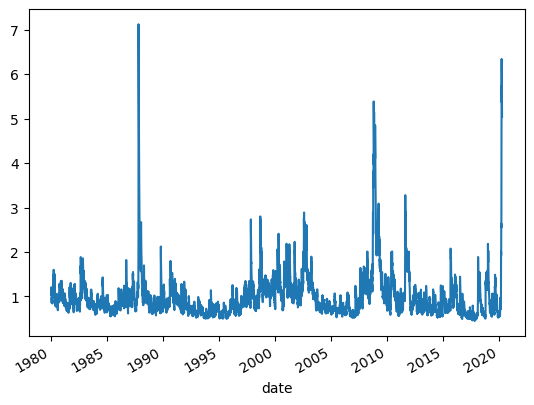

In [34]:
GARCH11_results.conditional_volatility.plot();

Suppose you ignore the fact that the volatility of the S&P 500 index portfolio is persistent and predictable. In that case, the best prediction of variance of daily returns for all future days is just the sample volatility, which we label $\hat{\sigma}^2$ and can calculate with the "var()" function in Python. 
Going back to the formula above, we would then say the variance of the distribution of returns over the next $K$ days is just 
$$
Var(r_{t \to t+K}) = Var(r_{t+1}) + Var(r_{t+2}) + ... + Var(r_{t+K}) = \underbrace{\hat{\sigma}^2 + ... + \hat{\sigma}^2 }_{\text{K times}} = K \times \hat{\sigma}^2
$$
and the standard deviation is the square root of this, or $\sqrt{K} \times \hat{\sigma}$.

So for example, the **1-day 5% value-at-risk** is the 5th percentile of a normal distribution with mean $\hat{\mu}$ and standard deviation $\hat{\sigma}$, which is (approximately) $\hat{\mu} - 1.645 \times \hat{\sigma}$. And we will apply a negative sign, to make sure we are reporting a positive number.

In [35]:
mu = returns.mean()
sigma = returns.std()
percentile = mu - 1.645*sigma
VAR = -percentile

print(f"Mean of the distribution of tomorrow's return: {mu:.6f}")
print(f"Volatility (standard deviation) of that distribution: {sigma:.6f}")
print(f"5th percentile of the distribution: {percentile:.6f}")
print(f"1-day 5% VAR: {VAR:.6f}")

Mean of the distribution of tomorrow's return: 0.000420
Volatility (standard deviation) of that distribution: 0.011249
5th percentile of the distribution: -0.018084
1-day 5% VAR: 0.018084


In words, we have only a 5% chance of losing more than 1.81% of our portfolio on any given day.

And the **30-day 5% value-at-risk** is the 5th percentile of a normal distribution with mean $30 \times \hat{\mu}$ and standard deivation $\sqrt{30} \times \hat{\sigma}$:

In [36]:
mu = 30*returns.mean()
sigma = math.sqrt(30)*returns.std()
percentile = mu - 1.645*sigma
VAR = -percentile

print(f"30-day 5% VAR: {VAR:.6f}")

30-day 5% VAR: 0.088744


So we would say that over any 30-day horizon, we have only a 5% chance of losing more than 8.9% of our portfolio.

But do you see the problem here? Our data ends in March of 2020. If we think of this calculation as forecasting the horizon immediately after that, then we are doing this analysis at a moment of all-time high volatility. But the calculations we just performed ignore this fact and just tell us about our value at risk on a "typical" day. This is not very useful as a guide to measuring our risk at this particular moment in time! 

The fundamental idea of the GARCH model is to extract a sense of what volatility is *right now*, and also, where it is likely to go in the near future based on the historical patterns of persistence in volatility. Then we can get a more sensible idea of how much risk we will really experience over the upcoming days.

### Completing the calculation, modeling volatility with the GARCH(1,1) results from earlier

Our GARCH approach gave us estimates $\hat{\sigma}_t$ that change over time, as opposed to a single constant number $\hat{\sigma}$, and it also gave us a model for how the value of $\hat{\sigma}_t$ today predicts future values of $\hat{\sigma}$ at different horizons. Based on this we can refine our VAR calculations.

Reconsider the distribution of returns over the next $K$ days. We would still forecast that the mean of this distribution is $K \times \hat{\mu}$, because our model did not imagine any predictability in returns.

The variance is the part that changes. Go back to this formula from before:
$$ Var(r_{t \to t+k}) = Var(r_t) + Var(r_{t+1}) + ... + Var(r_{t+K}) $$
That is, the variance of returns over the next $K$ days is the sum of the forecasted volatility on each of those days.

This formula is still valid, but now we don't just replace each term with $\hat{\sigma}^2$ as we did before. Instead, we replace with the forecasts that are generated by the GARCH model, which will take into account the 
predictability of future values of $\sigma^2$ based on what we measure today.

As with ARIMA, the ARCH package in Python gives us a forecast() function that can perform all these steps for us, so we will start by just using that:

For a **1-day 5% value at risk**, we calculate the 5th percentile of a normal distribution with mean and variance given by a 1-day ahead forecast from the GARCH model:

The forecast() function generates an object of forecast information, which I save with the name "forecast".

In [37]:
forecast = GARCH11_results.forecast(horizon=1)

It includes forecasts of both the mean and the variance of returns for the specified number of dates, which you can access by forecast.mean and forecast.variance. However, an annoying complication is that these are both actually Dataframes not just numbers. To get a specific number out of them, we have to access by row and column. There are several ways to do this. The easiest are:
- You can use "iloc[x,y]" where x is the row number and y is the column number. Remember that we count from 0.
- You can use "loc['row','col']" replacing these strings with the actual row and column names, which in this case are '2020-03-31' and 'h.1'.

There are also many other ways and it doesn't really matter for us how you do it.

The forecasted mean return tomorrow is just the value of $\mu$ that the computer estimated when it fit the GARCH model:

In [38]:
GARCH11_results.params['mu']

np.float64(0.07013283066369849)

In [39]:
forecast.mean

,h.1
date,
2020-03-31,0.070133


In [40]:
forecast.mean.iloc[0,0]

np.float64(0.07013283066369849)

In [41]:
forecast.mean.loc['2020-03-31','h.1']

np.float64(0.07013283066369849)

The forecasted variance of tomorrow's return follows a more complicated formula discussed at the end of this notebook, so we won't try to show where it comes from now, but here is how you would get the forecast out of statsmodels:

In [42]:
forecast.variance

,h.1
date,
2020-03-31,22.915132


In [43]:
forecast.variance.iloc[0,0]

np.float64(22.91513219128324)

In [44]:
forecast.variance.loc['2020-03-31','h.1']

np.float64(22.91513219128324)

So let's use these numbers in our VAR formula. We have to make two small adjustments. 
- First, forecast.variance is giving us the forecasted value of $\sigma^2$ but we want just $\sigma$ in the formula. So we will take the square root of that number using the math.sqrt() function.
- Second, we multiplied all the data by 100 before estimating the GARCH model to improve performance, so the forecasts that it gives us are 100x bigger than the original data. So we will just divide by 100 before plugging into the VAR formula.

In [45]:
mu = forecast.mean.iloc[0,0] / 100
sigma = math.sqrt(  forecast.variance.iloc[0,0]  ) / 100
percentile = mu - 1.645*sigma
VAR = -percentile

print(f"1-day 5% VAR: {VAR :.5f}")

1-day 5% VAR: 0.07804


In words, we have a 5% chance of losing more than 7.8% of our portfolio during the next day immediately following the end of the data (April 1, 2020). This is a much bigger VAR than we calculated earlier, which makes sense because we are now taking into account that volatility *right now* is much higher than the typical level.

And for a **30-day value at risk:** First, we retrieve forecasts of $y_t$ and $\sigma_t$ for the next 30 days.
The mean and variance of the distribution of returns over the next 30 days, is the sum of the means and variances that are forecasted for each of the next 30 days. The standard deviation is the square root of the variance. Then we just use the same formula for VAR based on this mean and standard deviation.

Create another forecast object, this time forecasting 30 days ahead:

In [46]:
forecast = GARCH11_results.forecast(horizon=30)

Here are the forecasted mean returns over the next 30 days. As before, this is just the estimated value of $\mu$, now copied over for each day:

In [47]:
forecast.mean

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,...,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133,0.070133


The forecasted mean return over the whole 30-day window is the sum of these values, which we can calculate using the sum() function.

(Python details: Again, we have to be careful that forecast.mean is a table, so Python will not understand what it means to "sum" this table, even though the meaning seems obvious to us since the table only has one row. Instead we have to access that row itself, and then sum that. We can access the row using iloc[0] or loc['2020-03-31'].)

In [48]:
forecast.mean.iloc[0].sum()

np.float64(2.103984919910955)

To compare with the notation in the slides, this is just the same thing as $K \times \mu$ where $K=30$ and $\mu$ is the estimated value from the GARCH model.

In [49]:
30*GARCH11_results.params['mu']

np.float64(2.1039849199109546)

Here's the table of forecasts of $\sigma_t^2$ over the next 30 days, one forecast for each day.

In [50]:
forecast.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,22.915132,22.599708,22.288882,21.982587,21.680758,21.383328,21.090234,20.801412,20.516801,20.236339,...,17.408401,17.173252,16.94153,16.713187,16.488172,16.266437,16.047935,15.832618,15.62044,15.411355


Notice how forecasted $\sigma_t^2$ starts out at a similar level to where the data ended, and decline slowly but surely towards the long-run average. The rate of that decline is something that the model learned by studying past times in the data when volatility spiked and then reverted to its long-run mean.

Again, we want to add up all the forecast $\sigma_t^2$ values to get the forecasted variance over the entire 30-day horizon.

In [51]:
forecast.variance.iloc[0].sum()

np.float64(567.2071115832056)

Finally we plug into our VAR formula with the same thought process as in our earlier 1-day example:

In [52]:
mu = forecast.mean.iloc[0].sum() / 100
sigma = math.sqrt( forecast.variance.iloc[0].sum() ) / 100
percentile = mu - 1.645*sigma
VAR = -percentile

print(f"30-day 5% VAR: {VAR :.4f}" )

30-day 5% VAR: 0.3707


So over the next 30 days, we have a 5% chance of losing 37% of our portfolio our more. This is pretty scary, and a much more reasonable number to report in April of 2020 than what we calculated before!

### Calculating the forecasts manually

In practice, you would calculate the volatility forecasts using software. But to understand that process better, here is some code to match those forecasts manually:

As we mentioned before, the mean forecasts at every future date are just the estimate of $\mu$ that came out of the estimation results. This is because the model that we estimated for returns in the first place was just $r_t = \mu + u_t$. So when we add up these numbers over the next $K$ days, we are really just calculating $K \times \mu$.

(By the way, there is nothing forcing you to use such a boring model for this part of the analysis. You could have an ARMA model for some data $y$ that generates time series effects and complicated forecasts, along with a GARCH model for the variance of the shocks affecting $y$. However, in practice it happens that GARCH effects are most important to capture in financial prices, where we tend to assume and find that there is basically no predictability in returns. So it actually does not come up very often that you need to combine these two things. Typically if you are doing any GARCH analysis, you are looking at a data series where it's reasonable to assume there is no predictability at all, and you would model that as we do here, $r_t = \mu + u_t$.)

The variance forecasts at future dates are the more complicated part. They can be calculated from the model estimates, following a similar logic to the earlier ARMA section of the course:

- Label $T$ as the end of the dataset (in this case, March 31 2020). 
- Our GARCH model says $\sigma_{T+1}^2 = \omega + \alpha \times u_T^2 + \beta \times \sigma_T^2$. 
- As of time $T$, we would forecast $\sigma_{T+1}^2$ by substituting in our data or best estimates of these quantities. 
- We can access the estimates of $\omega$, $\alpha$, and $\beta$ from the "params" object that came with the model results:

In [53]:
print( GARCH11_results.params )

mu          0.070133
omega       0.018623
alpha[1]    0.097972
beta[1]     0.887451
Name: params, dtype: float64


- We can also see the model's estimate of the very last volatility $\hat{\sigma}_T$, and the last model residual $\hat{u}_T$, from the "conditional_volatility" and "resid" objects:

In [54]:
print( GARCH11_results.conditional_volatility[-1] ) 
print( GARCH11_results.resid[-1] ) 

5.04871818381542
-1.677786610434104


Substituting these into the formula, we get the first variance forecast:

In [55]:
variance_forecast_1 = GARCH11_results.params['omega'] + GARCH11_results.params['alpha[1]']*GARCH11_results.resid[-1]**2 \
      + GARCH11_results.params['beta[1]']*GARCH11_results.conditional_volatility[-1]**2

print( "Forecast of variance one day past the end of the data: ")
print( variance_forecast_1 )

Forecast of variance one day past the end of the data: 
22.91513219128324


Moving forward one date, the model says $\sigma_{T+2}^2 = \omega + \alpha \times u_{T+1}^2 + \beta \times \sigma_{T+1}^2$. It may not be obvious, but our best forecast of $u_{T+1}^2$ is in fact the same thing as our best forecast of $\sigma_{T+1}^2$. So for both of these quantities, we substitute the forecast we just calculated above.

In [56]:
variance_forecast_2 = GARCH11_results.params['omega'] + GARCH11_results.params['alpha[1]']*variance_forecast_1 \
      + GARCH11_results.params['beta[1]']*variance_forecast_1

print("Forecast of variance two days past the end of the data: ")
print( variance_forecast_2 )

Forecast of variance two days past the end of the data: 
22.599708158971676


Similarly, $\sigma_{T+3}^2 = \omega + \alpha \times u_{T+2}^2 + \beta \times \sigma_{T+2}^2$ and we substitute the forecast we just calculated for both of these quantities.

In [57]:
variance_forecast_3 = GARCH11_results.params['omega'] + GARCH11_results.params['alpha[1]']*variance_forecast_2 \
      + GARCH11_results.params['beta[1]']*variance_forecast_2

print("Forecast of variance three days past the end of the data: ")
print( variance_forecast_3 )

Forecast of variance three days past the end of the data: 
22.288882241016882


Compare with the forecasts that were automatically generated for us:

In [58]:
print( forecast.variance.iloc[-1][0:5])

h.01    22.915132
h.02    22.599708
h.03    22.288882
h.04    21.982587
h.05    21.680758
Name: 2020-03-31 00:00:00, dtype: float64
